In [1]:
%matplotlib inline

In [2]:
import sys
sys.path += ['../']
import matplotlib.pyplot as plt
from src.data.preprocess import run_pca
from src.data.make_dataset import load_dataset, load_subjects
from sklearn import svm
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import hcp
import mne
import numpy as np

In [51]:
dataset = load_dataset('../data/processed/hcp', '../data/hcp-train.csv')
testdataset = load_dataset('../data/processed/hcp', '../data/hcp-eval.csv')

In [53]:
def transform_data(data, channels):
    """Select a number of channels from each data record and concatenate them into a single vector"""
    
    return [np.ravel(d[0][:channels]) for d in data['data']]    

In [54]:
channels = 10

dd = transform_data(dataset, channels)
td = transform_data(testdataset, channels)

In [73]:
len(dd)

2505

In [56]:
model = svm.SVC(gamma=0.01, C=10.)
model.fit(dd, dataset['age'])

SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [57]:
def evaluate(model, key, data, ref):

    predicted = model.predict(data)
    print("{:.2f}% correct".format(100*accuracy_score(ref[key], predicted)))
    print(confusion_matrix(ref[key], predicted))

In [58]:
evaluate(model, 'age', dd, dataset)

99.96% correct
[[815   0   0]
 [  0 822   0]
 [  0   1 867]]


In [59]:
evaluate(model, 'age', td, testdataset)

46.13% correct
[[ 41 121   0]
 [ 93 116  17]
 [  3  93 123]]


In [60]:
rfmodel = RandomForestClassifier(n_estimators=100)
rfmodel.fit(dd, dataset['age'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [61]:
evaluate(rfmodel, 'age', dd, dataset)

100.00% correct
[[815   0   0]
 [  0 822   0]
 [  0   0 868]]


In [62]:
evaluate(rfmodel, 'age', td, testdataset)

47.45% correct
[[ 51 107   4]
 [ 92  90  44]
 [  6  66 147]]


In [63]:
model = svm.SVC(gamma=0.01, C=10.)
model.fit(dd, dataset['gender'])


SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [64]:
evaluate(model, 'gender', dd, dataset)

100.00% correct
[[ 931    0]
 [   0 1574]]


In [65]:
evaluate(model, 'gender', td, testdataset)

82.70% correct
[[224   1]
 [104 278]]


In [66]:
def show(n):
    data = dd[n]
    data = data.reshape(channels,24)
    plt.pcolor(data)
    print(dataset['age'][n], dataset['gender'][n])


22-25 F


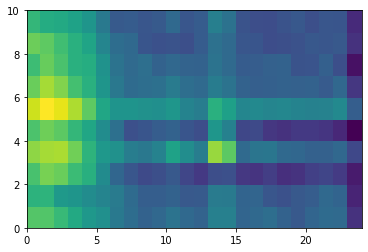

In [67]:
show(0)

26-30 F


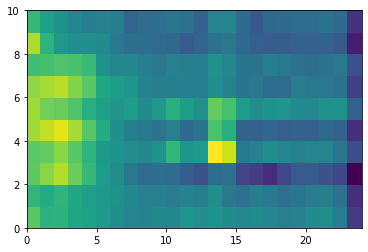

In [70]:
show(1000)

31-35 F


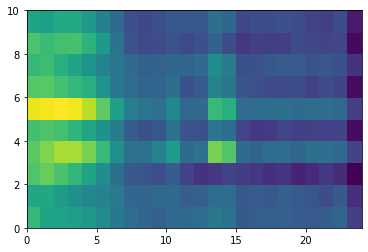

In [72]:
show(2001)